In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings

In [2]:
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 10

%matplotlib inline

warnings.filterwarnings("ignore")

In [3]:
data =pd.read_csv('Analyst_Coverage.csv')

1.Which company has the higher analyst coverage? (Look at histogram) \
2. Which analyst covers the most companies? (Look at histogram) \
3. Based on how analysts organize themselves into covering companies, 
> a. Could you model the similarity or conversely, the distance matrix 
between the companies based on this analyst co-coverage \
b. How would the results change if you were to restrict the dataset to
only analysts having companies covered within 1s.d. of the
distribution found in Qn. 2? \
c. If further restricted to a smaller subset? 
> 
4. Which sectors are the most heterogenous? (Look at the clusters formed
by industry groups per sector – use t-SNE to visualize) 
5. Similarly, which sectors are the most homogenous? 
6. What type of companies tend to be outliers in terms of the clusters? 
7. Feel free to explore and provide deeper insights in the structure of the
clusters/network as part of the outputs. 

## Question 1

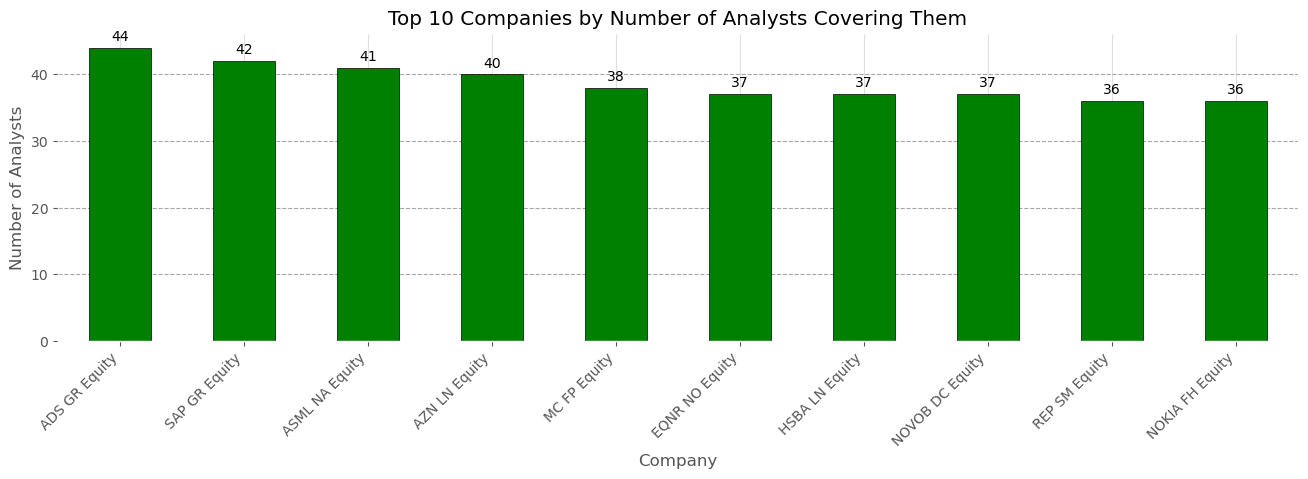

In [4]:
analyst_coverage = data['ANALYST'].value_counts()
company_coverage = data['BBTICKER'].value_counts()

# Get the top 10 companies with the most analyst coverage
top_10_company_coverage = company_coverage.head(10)

# Plot the bar chart for the top 10 companies
plt.figure(figsize=(16, 4))
bars = top_10_company_coverage.plot(kind='bar', edgecolor='black', color='g')
plt.title('Top 10 Companies by Number of Analysts Covering Them')
plt.xlabel('Company')
plt.ylabel('Number of Analysts')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.0f'),
                  xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  xytext=(0, 3), 
                  textcoords="offset points",
                  ha='center', va='bottom')
plt.show()

## Question 2

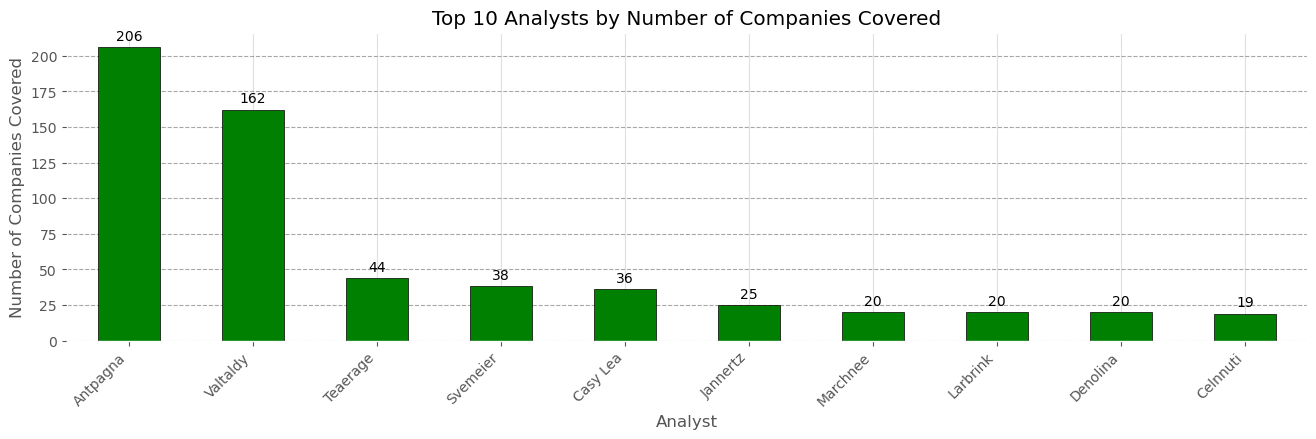

In [5]:
# Sort the data by the number of companies covered by each analyst and get the top 10
sorted_analyst_coverage = analyst_coverage.sort_values(ascending=False).head(10)

# Plot the bar chart for the top 10 analysts with the number of companies shown on each bar
plt.figure(figsize=(16, 4))
bars = sorted_analyst_coverage.plot(kind='bar', edgecolor='black', color='g')
plt.title('Top 10 Analysts by Number of Companies Covered')
plt.xlabel('Analyst')
plt.ylabel('Number of Companies Covered')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the number of companies on each bar
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.0f'),
                  xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom')

plt.show()

## Question 3a

### Cosine Similarity

In [6]:
company_analyst_matrix = pd.crosstab(data['BBTICKER'], data['ANALYST'])

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

matrix_1 = cosine_similarity(company_analyst_matrix)
matrix_1_df = pd.DataFrame(matrix_1, index=company_analyst_matrix.index, columns=company_analyst_matrix.index)
#matrix_1_df.head()

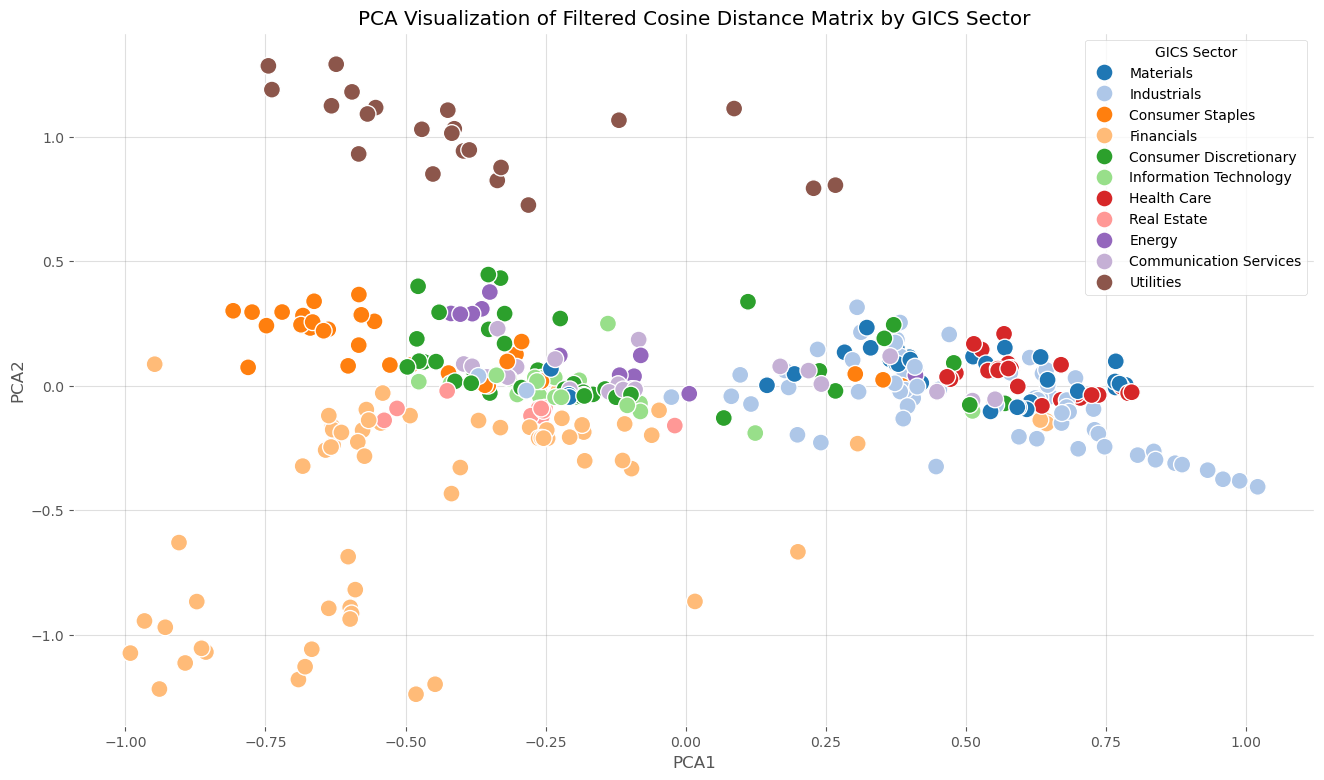

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_results = pca.fit_transform(matrix_1_df)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_results, columns=['PCA1', 'PCA2'])
pca_df['Company'] = matrix_1_df.index

# Merge the sector information into the PCA results
pca_df = pca_df.merge(data[['BBTICKER', 'GICS_SECTOR_NAME']].drop_duplicates(), left_on='Company', right_on='BBTICKER')

# Plot the PCA results with GICS sector information
plt.figure(figsize=(16, 9))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='GICS_SECTOR_NAME', palette='tab20', s=150)

# Add title and labels
plt.title('PCA Visualization of Filtered Cosine Distance Matrix by GICS Sector')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(loc='best', bbox_to_anchor=(1, 1), title='GICS Sector')
plt.show()

<Figure size 3000x3000 with 0 Axes>

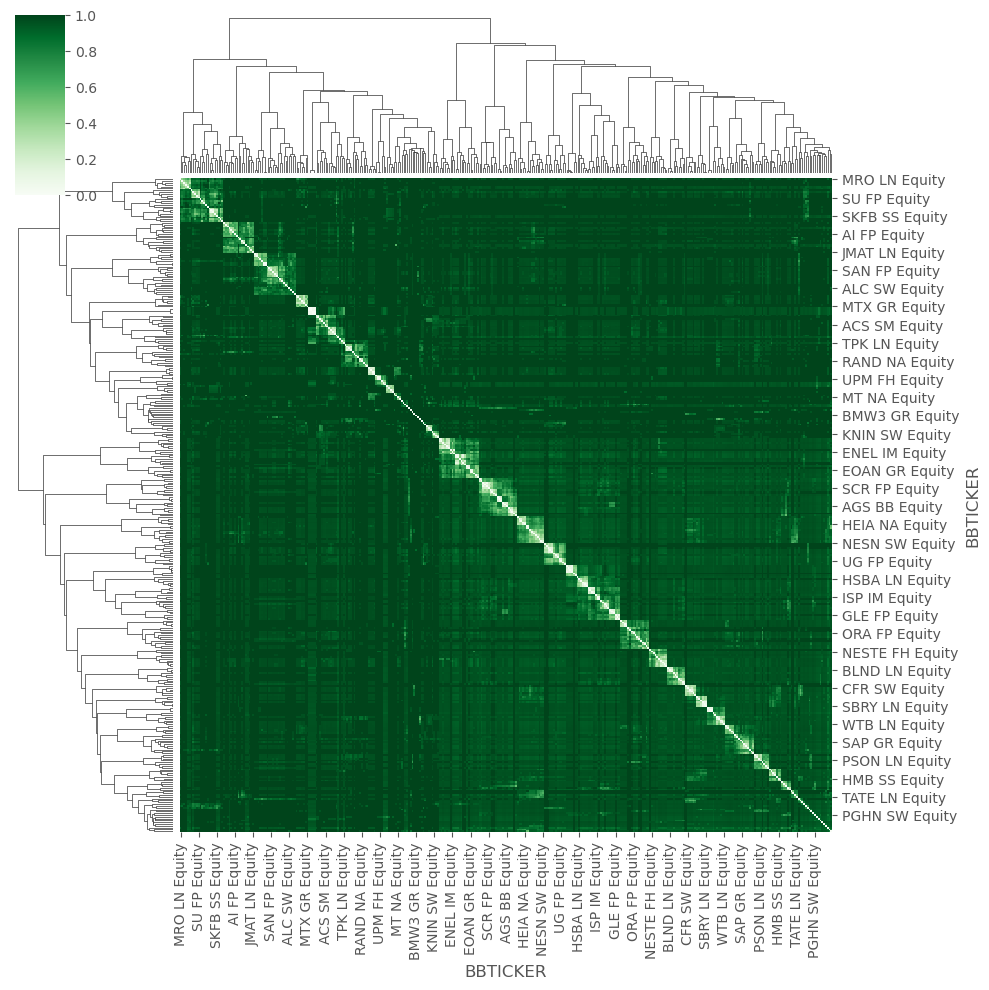

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage

distance_matrix_filtered = 1 - matrix_1_df

linkage_matrix = linkage(distance_matrix_filtered, method='ward')

# Plot the clustered heatmap
plt.figure(figsize=(30, 30))
sns.clustermap(distance_matrix_filtered, row_linkage=linkage_matrix, col_linkage=linkage_matrix, cmap='Greens')
#plt.title('Distance Based on Analyst Co-Coverage')
plt.show()

## Question 3b

In [10]:
mean_coverage = analyst_coverage.mean()
std_coverage = analyst_coverage.std()

analysts_within_1sd = analyst_coverage[(analyst_coverage >= (mean_coverage - std_coverage)) & (analyst_coverage <= (mean_coverage + std_coverage))].index

In [11]:
filtered_data = data[data['ANALYST'].isin(analysts_within_1sd)]
filtered_matrix = pd.crosstab(filtered_data['BBTICKER'], filtered_data['ANALYST'])#.astype(bool).astype(int)
filtered_matrix_cosine = cosine_similarity(filtered_matrix)
filtered_matrix_cosine_df = pd.DataFrame(filtered_matrix_cosine, index=filtered_matrix.index, columns=filtered_matrix.index)

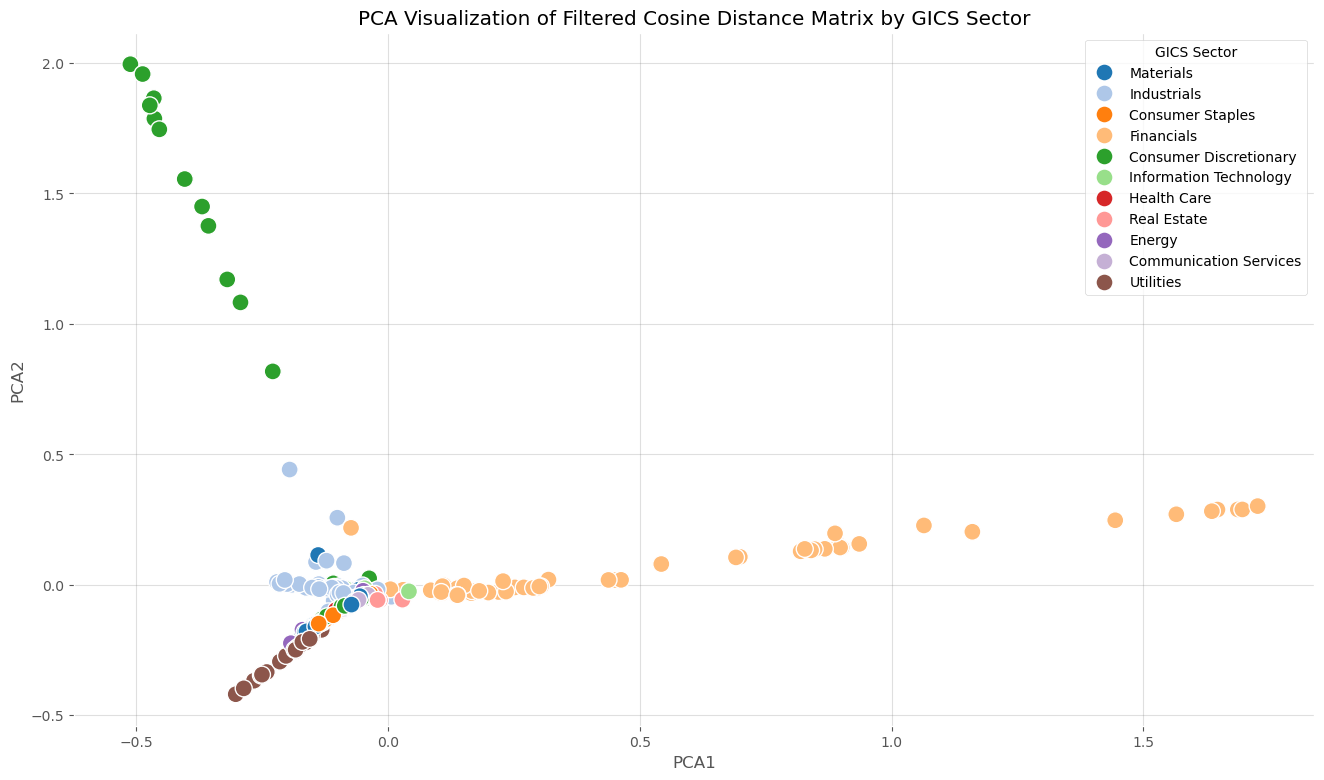

In [12]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(filtered_matrix_cosine_df)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_results, columns=['PCA1', 'PCA2'])
pca_df['Company'] = filtered_matrix_cosine_df.index

# Merge the sector information into the PCA results
pca_df = pca_df.merge(data[['BBTICKER', 'GICS_SECTOR_NAME']].drop_duplicates(), left_on='Company', right_on='BBTICKER')

# Plot the PCA results with GICS sector information
plt.figure(figsize=(16, 9))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='GICS_SECTOR_NAME', palette='tab20', s=150)

# Add title and labels
plt.title('PCA Visualization of Filtered Cosine Distance Matrix by GICS Sector')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(loc='best', bbox_to_anchor=(1, 1), title='GICS Sector')
plt.show()

<Figure size 2000x2000 with 0 Axes>

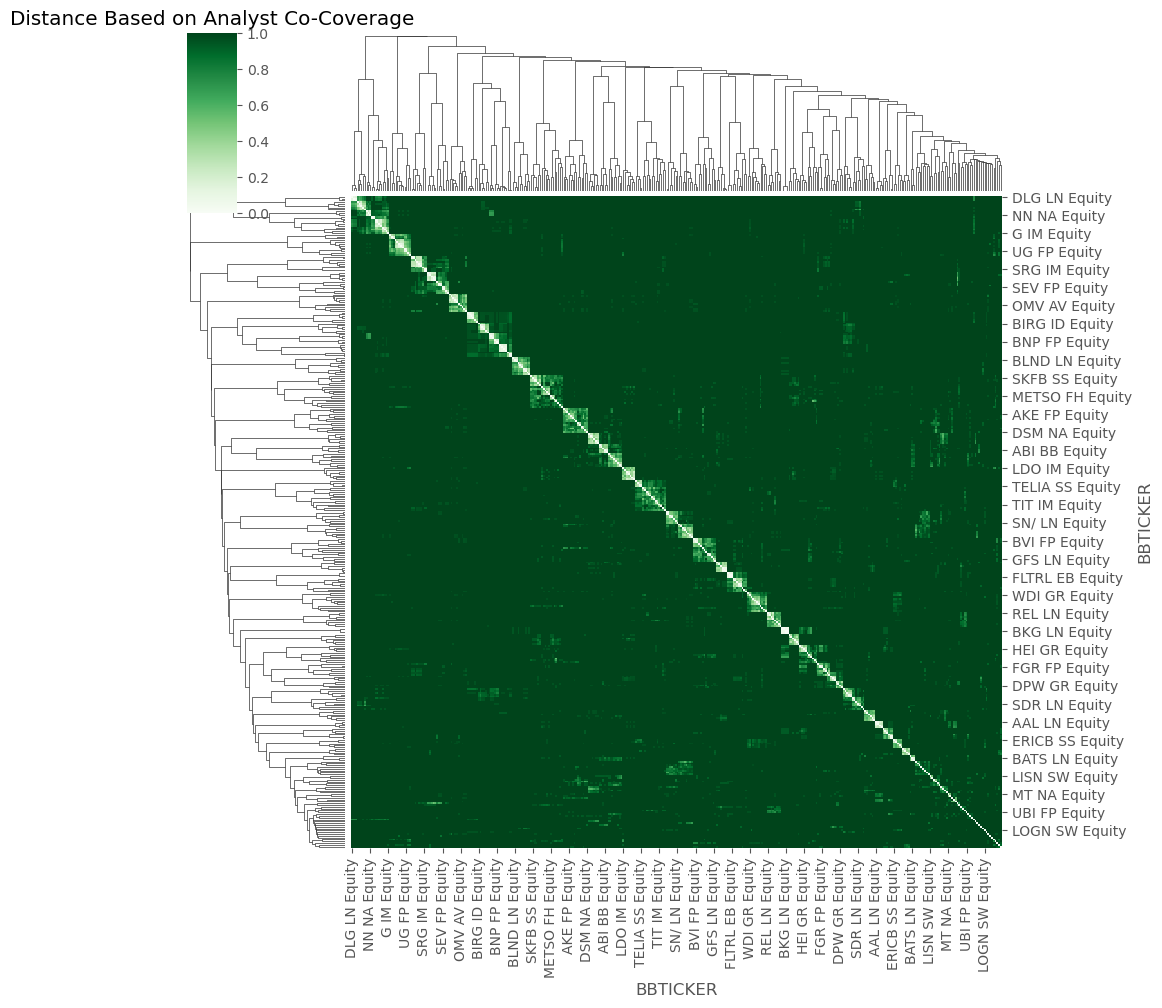

In [13]:
distance_matrix_filtered1 = 1 - filtered_matrix_cosine_df

linkage_matrix1 = linkage(distance_matrix_filtered1, method='ward')

# Plot the clustered heatmap
plt.figure(figsize=(20, 20))
sns.clustermap(distance_matrix_filtered1, row_linkage=linkage_matrix1, col_linkage=linkage_matrix1, cmap='Greens')
plt.title('Distance Based on Analyst Co-Coverage')
plt.show()

## Question 3c

In [14]:
analysts_within_0_5sd = analyst_coverage[(analyst_coverage >= (mean_coverage - 0.5 * std_coverage)) & (analyst_coverage <= (mean_coverage + 0.5 * std_coverage))].index

In [15]:
filtered_data1 = data[data['ANALYST'].isin(analysts_within_0_5sd)]
filtered_matrix1 = pd.crosstab(filtered_data1['BBTICKER'], filtered_data1['ANALYST']).astype(bool).astype(int)
filtered_matrix_cosine1 = cosine_similarity(filtered_matrix1)
filtered_matrix_cosine_df1 = pd.DataFrame(filtered_matrix_cosine1, index=filtered_matrix1.index, columns=filtered_matrix1.index)

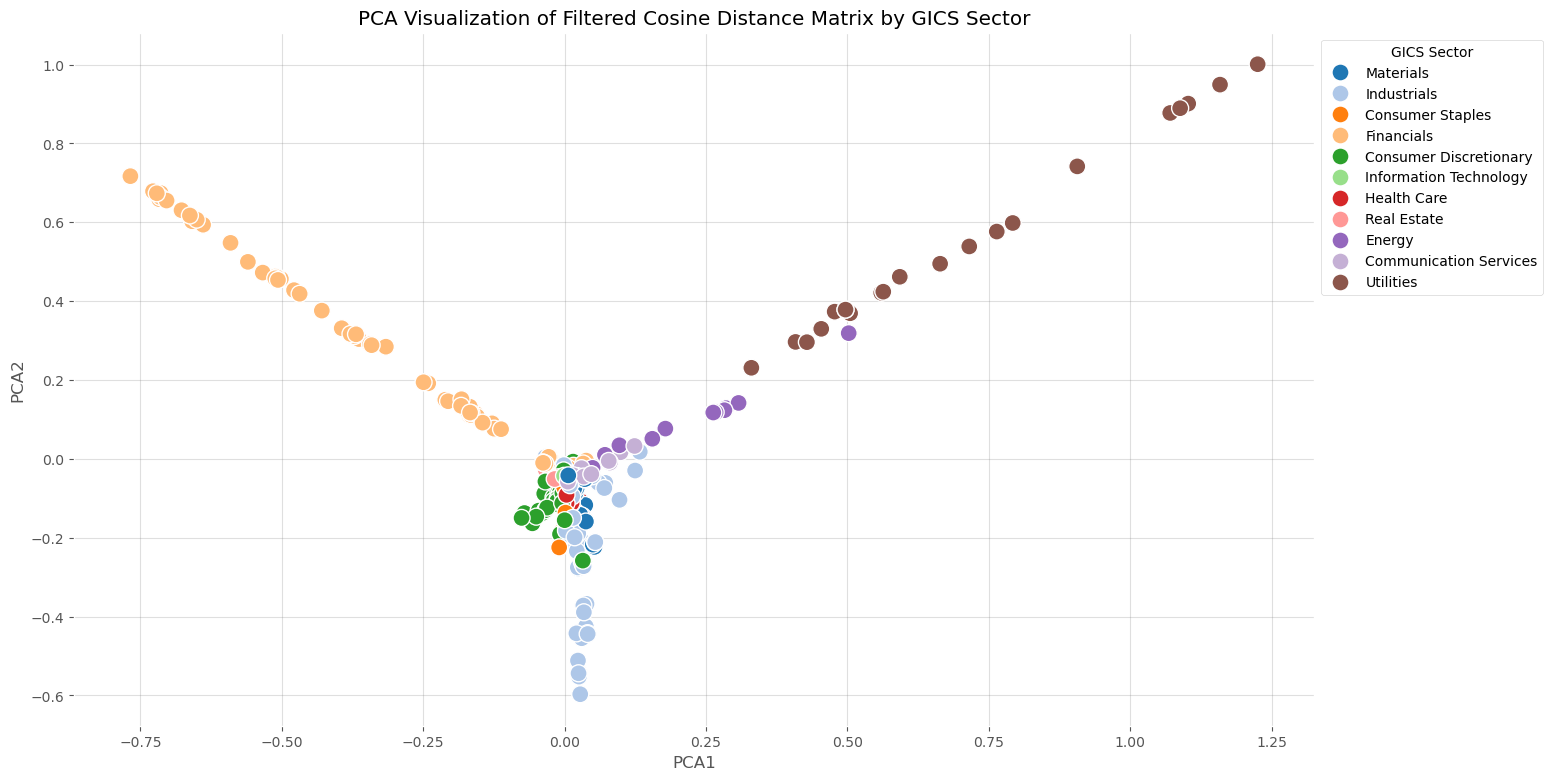

In [16]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(filtered_matrix_cosine_df1)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_results, columns=['PCA1', 'PCA2'])
pca_df['Company'] = filtered_matrix_cosine_df1.index

# Merge the sector information into the PCA results
pca_df = pca_df.merge(data[['BBTICKER', 'GICS_SECTOR_NAME']].drop_duplicates(), left_on='Company', right_on='BBTICKER')

# Plot the PCA results with GICS sector information
plt.figure(figsize=(16, 9))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='GICS_SECTOR_NAME', palette='tab20', s=150)

# Add title and labels
plt.title('PCA Visualization of Filtered Cosine Distance Matrix by GICS Sector')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(loc='best', bbox_to_anchor=(1, 1), title='GICS Sector')
plt.show()

<Figure size 2000x2000 with 0 Axes>

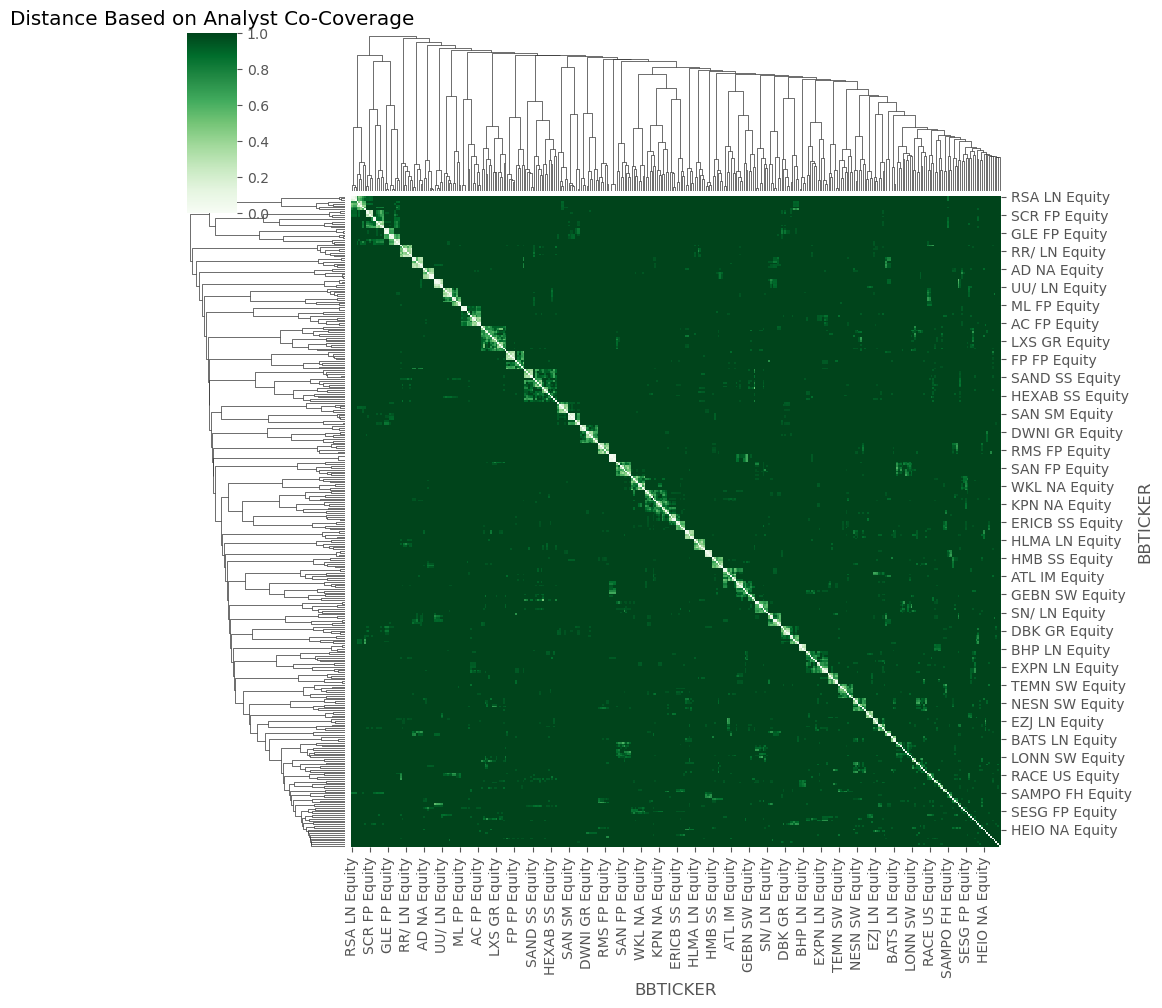

In [17]:
distance_matrix_filtered2 = 1 - filtered_matrix_cosine_df1

linkage_matrix2 = linkage(distance_matrix_filtered2, method='ward')

# Plot the clustered heatmap
plt.figure(figsize=(20, 20))
sns.clustermap(distance_matrix_filtered2, row_linkage=linkage_matrix2, col_linkage=linkage_matrix2, cmap='Greens')
plt.title('Distance Based on Analyst Co-Coverage')
plt.show()

### Analysis and Observations (From chatgpt)

#### 1. **First Graph (Reduced to 0.5 SD):**
- **Clusters:** The PCA plot shows distinct clustering of companies within the Financials, Consumer Staples, and Information Technology sectors.
- **Separation:** There is a notable separation between the clusters, indicating that the companies within these sectors have high cosine similarity and thus are closer together.
- **Spread:** The companies are more tightly clustered, indicating a higher degree of similarity among the companies that remain after filtering to 0.5 SD. This tighter clustering is likely due to the more stringent filtering, leaving only those analysts who have a very consistent coverage pattern.

#### 2. **Second Graph (Reduced to 1 SD):**
- **Clusters:** Clustering is still present but less distinct compared to the 0.5 SD reduction. There is still a separation of sectors, but the boundaries between clusters are less defined.
- **Separation:** The clusters are somewhat more spread out compared to the 0.5 SD reduction, indicating a slightly more diverse set of analyst coverages.
- **Spread:** The companies are more spread out compared to the 0.5 SD reduction, indicating that the inclusion of a larger number of analysts introduces more variability in the coverage patterns.

#### 3. **Third Graph (All Data, No Reduction):**
- **Clusters:** Clustering is less distinct, and there is significant overlap between sectors.
- **Separation:** The separation between clusters is minimal, indicating that companies from different sectors are more mixed. This suggests that when including all analysts, there is a higher diversity in coverage patterns.
- **Spread:** The companies are much more spread out compared to the 0.5 SD and 1 SD reductions, indicating a wide range of analyst coverages and less consistency in the analyst patterns.

### Conclusions:
- **Clustering and Separation:** As the dataset is restricted more stringently (from no reduction to 1 SD to 0.5 SD), the clusters become more distinct, and there is greater separation between different sectors. This indicates that a more consistent analyst coverage pattern results in clearer distinctions between sectors.
- **Spread of Companies:** The spread of companies increases as the restriction is lessened. With no restriction, the companies are highly spread out, indicating diverse analyst coverage. With a 0.5 SD reduction, the companies are tightly clustered, indicating high similarity in analyst coverage.
- **Impact of Analyst Coverage Consistency:** The consistency in analyst coverage greatly affects the similarity between companies. More consistent analyst coverage (seen in the 0.5 SD reduction) results in higher similarity and clearer clustering, whereas less consistent coverage (no reduction) results in lower similarity and more mixed clusters.

### Observations:
- **Sector-Specific Insights:** Certain sectors like Financials, Consumer Staples, and Information Technology tend to form more distinct clusters even with less stringent filtering (1 SD reduction), suggesting more consistent coverage patterns within these sectors.
- **Mixing of Sectors:** With no reduction, sectors mix significantly, indicating that analysts cover a broad range of companies, and there is less distinction in their coverage patterns.
- **Potential for Further Analysis:** Further analysis could involve examining specific sectors more closely to understand the drivers behind the clustering patterns and how individual analysts' coverage impacts the similarity and distance matrices.

These observations provide insights into how the consistency of analyst coverage affects the similarity and clustering of companies within different sectors.

## Question 4 & 5

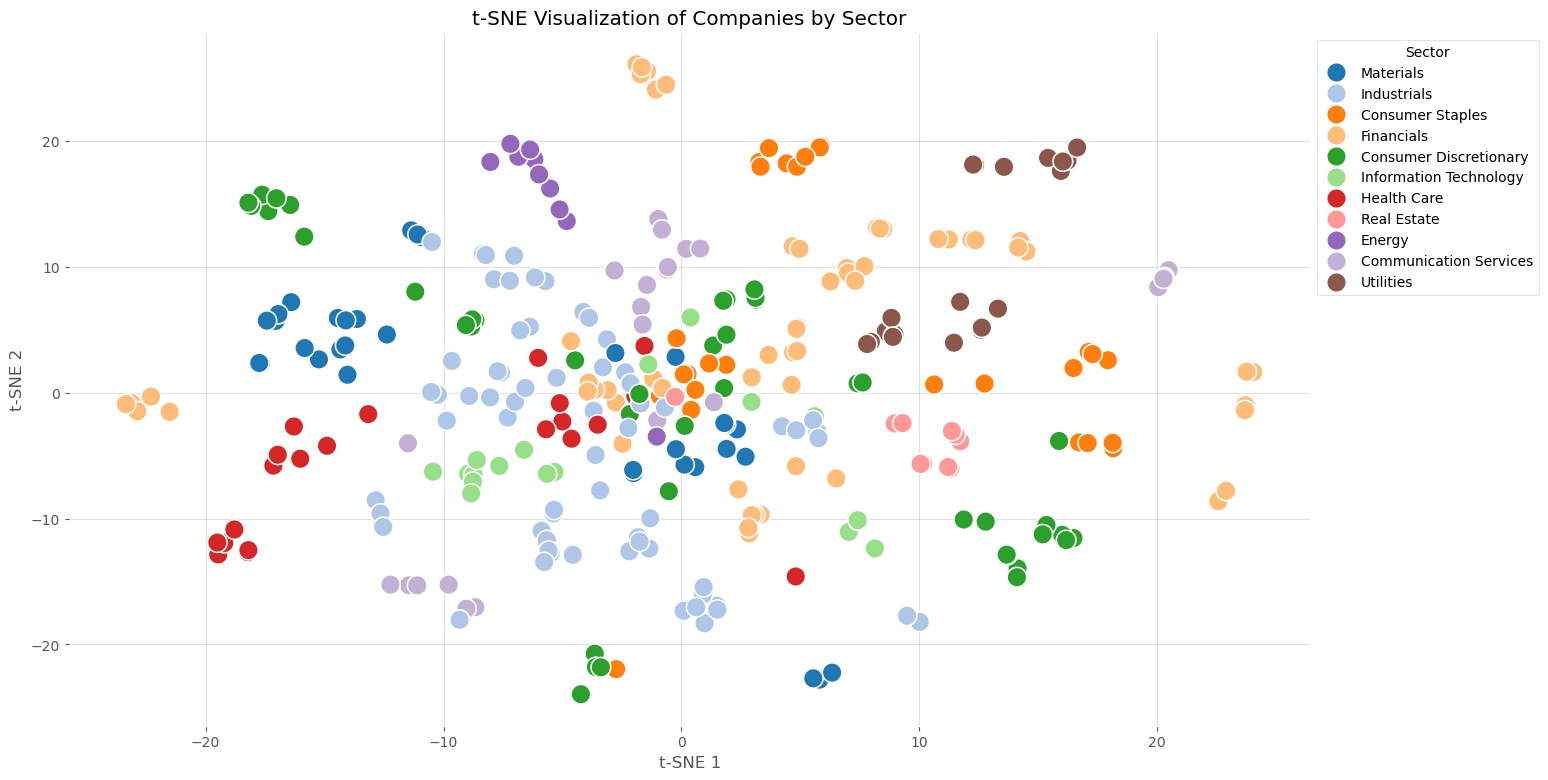

In [18]:
from sklearn.manifold import TSNE
import matplotlib.patches as patches

#sampled_data = filtered_matrix_cosine_df1.sample(n=50, random_state=42)

#tsne = TSNE(n_components=2, random_state=42)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_embedding = tsne.fit_transform(company_analyst_matrix)

# Convert t-SNE embedding to a DataFrame
tsne_df = pd.DataFrame(tsne_embedding, index=company_analyst_matrix.index, columns=['t-SNE 1', 't-SNE 2'])

# Merge with the original data to get the sectors
tsne_df = tsne_df.merge(data[['BBTICKER', 'GICS_SECTOR_NAME']].drop_duplicates(), left_index=True, right_on='BBTICKER')

# Step 8: Visualize the t-SNE embedding
plt.figure(figsize=(16, 9))
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='GICS_SECTOR_NAME', data=tsne_df, palette='tab20', s=200)
plt.title('t-SNE Visualization of Companies by Sector')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(loc='best', bbox_to_anchor=(1, 1), title='Sector')
plt.show()

In [19]:
from scipy.spatial.distance import pdist

# Calculate pairwise distances within each sector
sector_heterogeneity = {}

for sector in tsne_df['GICS_SECTOR_NAME'].unique():
    sector_points = tsne_df[tsne_df['GICS_SECTOR_NAME'] == sector][['t-SNE 1', 't-SNE 2']].values
    if len(sector_points) > 1:  # Avoid calculating for sectors with only one company
        distances = pdist(sector_points)
        avg_distance = np.mean(distances)
        sector_heterogeneity[sector] = avg_distance
    else:
        sector_heterogeneity[sector] = 0

# Display the sectors sorted by heterogeneity
heterogeneity_df = pd.DataFrame.from_dict(sector_heterogeneity, orient='index', columns=['Average Pairwise Distance'])
heterogeneity_df = heterogeneity_df.sort_values(by='Average Pairwise Distance', ascending=False)

print(heterogeneity_df)

                        Average Pairwise Distance
Consumer Discretionary                  19.501815
Financials                              18.664645
Communication Services                  18.323761
Materials                               15.099379
Consumer Staples                        15.025387
Industrials                             13.029790
Health Care                             11.712933
Information Technology                  10.413622
Utilities                                8.569191
Energy                                   6.207692
Real Estate                              4.024039


## Question 6

In [20]:
from sklearn.cluster import KMeans

num_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
tsne_df['Cluster'] = kmeans.fit_predict(tsne_df[['t-SNE 1', 't-SNE 2']])

# Add cluster centroids to the DataFrame for easier access
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns=['t-SNE 1', 't-SNE 2'])
centroid_df['Cluster'] = range(num_clusters)

# Calculate distance of each point to its cluster centroid
tsne_df['DistanceToCentroid'] = tsne_df.apply(
    lambda row: np.linalg.norm(row[['t-SNE 1', 't-SNE 2']] - centroids[row['Cluster']]),
    axis=1
)

# Identify outliers as points with the highest distances to their cluster centroids
outliers = tsne_df.sort_values(by='DistanceToCentroid', ascending=False).head(10)

print("Top 10 Outliers:")
outliers.head(10)

Top 10 Outliers:


,t-SNE 1,t-SNE 2,BBTICKER,GICS_SECTOR_NAME,Cluster,DistanceToCentroid
5324,20.469500,9.751842,TEL NO Equity,Communication Services,3,15.266300
6557,20.294365,9.175618,TEL2B SS Equity,Communication Services,3,14.666664
8007,10.013580,-18.216064,IAG LN Equity,Industrials,3,14.605020
5255,20.261648,9.067652,TELIA SS Equity,Communication Services,3,14.554372
8497,9.889330,-18.102818,EZJ LN Equity,Industrials,3,14.538626
2563,6.330512,-22.244501,GLEN LN Equity,Materials,4,14.439213
35,-19.507601,-11.904895,ROG SW Equity,Health Care,4,14.432154
1903,6.230252,-22.347122,AAL LN Equity,Materials,4,14.422201
1653,5.800098,-22.798409,BHP LN Equity,Materials,4,14.372365
8644,9.477920,-17.722576,LHA GR Equity,Industrials,3,14.325769


## Question 7

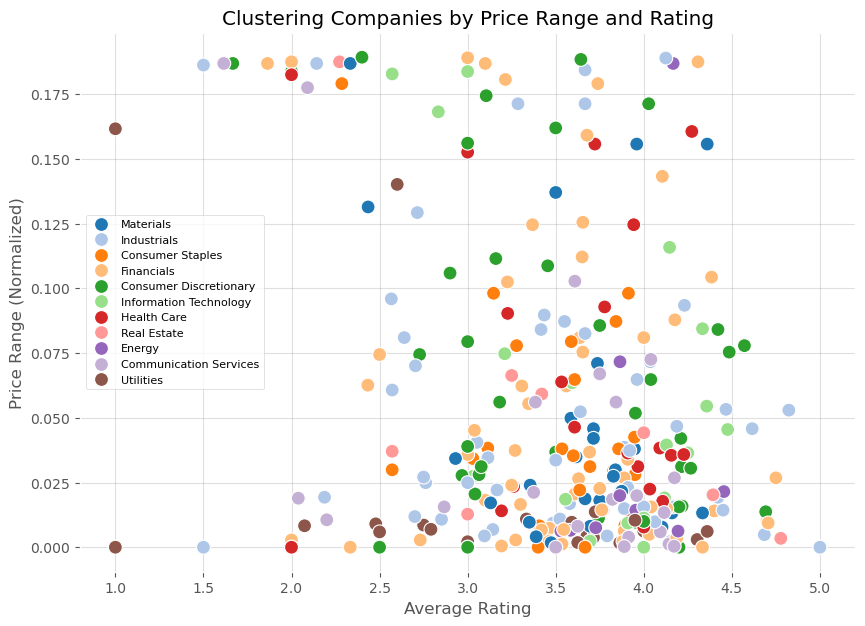

In [21]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load your data into a DataFrame


# Normalize the TARGET_PRICE column
scaler = StandardScaler()
data['TARGET_PRICE_NORMALIZED'] = scaler.fit_transform(data[['TARGET_PRICE']])

# Remove outliers in the normalized target prices
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1 * IQR
    upper_bound = Q3 + 1 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

data_clean = remove_outliers(data, 'TARGET_PRICE_NORMALIZED')

# Calculate the price range for each stock
price_range_data = data_clean.groupby(['BBTICKER', 'GICS_SECTOR_NAME']).agg({
    'TARGET_PRICE_NORMALIZED': lambda x: x.max() - x.min(),
    'RATING': 'mean'
}).reset_index()

# Rename columns for clarity
price_range_data.rename(columns={'TARGET_PRICE_NORMALIZED': 'PRICE_RANGE'}, inplace=True)

# Perform clustering
X = price_range_data[['PRICE_RANGE', 'RATING']]
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
price_range_data['CLUSTER'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=price_range_data, x='RATING', y='PRICE_RANGE', hue='GICS_SECTOR_NAME', palette='tab20', s=100)
plt.xlabel('Average Rating')
plt.ylabel('Price Range (Normalized)')
plt.title('Clustering Companies by Price Range and Rating')
plt.legend(loc = 'best', fontsize = 8)
plt.show()

In [22]:
high_price_range = price_range_data.sort_values(by = 'PRICE_RANGE').tail(100).copy()
filtered_high_price_range = high_price_range[high_price_range['RATING'] <= 3.5]
filtered_high_price_range['GICS_SECTOR_NAME'].value_counts()

GICS_SECTOR_NAME
Industrials               11
Consumer Discretionary    11
Financials                10
Information Technology     4
Real Estate                3
Consumer Staples           3
Health Care                3
Materials                  3
Utilities                  2
Communication Services     2
Name: count, dtype: int64

In [23]:
low_price_range = price_range_data.sort_values(by = 'PRICE_RANGE').head(100).copy()
filtered_low_price_range = low_price_range[low_price_range['RATING'] >= 3.5]
filtered_low_price_range['GICS_SECTOR_NAME'].value_counts()

GICS_SECTOR_NAME
Financials                11
Industrials               10
Utilities                  7
Consumer Staples           6
Communication Services     6
Consumer Discretionary     4
Real Estate                3
Information Technology     3
Materials                  2
Health Care                2
Energy                     2
Name: count, dtype: int64

In [24]:
rating_mapping = {
    'buy': 'Buy', 'equalweight': 'Hold', 'hold': 'Hold', 'overweight': 'Buy', 'add': 'Buy',
    'Overwt/In-Line': 'Buy', 'neutral': 'Hold', 'underperform': 'Sell', 'sell': 'Sell',
    'market perform': 'Hold', 'long-term outperform': 'Buy', 'reduce': 'Sell', 'peerperform': 'Hold',
    'underweight': 'Sell', 'not rated': 'Not Rated', 'Underwt/In-Line': 'Sell', 'outperform': 'Buy',
    'Underwt/Attractive': 'Sell', 'Underwt/Cautious': 'Sell', 'accumulate': 'Buy',
    'sector perform': 'Hold', 'suspended coverage': 'Not Rated', 'Equalwt/In-Line': 'Hold',
    'market outperform': 'Buy', 'sector weight': 'Hold', 'Rating Suspended': 'Not Rated',
    'withheld': 'Not Rated', 'Under Review': 'Not Rated', 'Equalwt/Cautious': 'Hold',
    'Equalwt/Attractive': 'Hold', 'corporate': 'Not Rated', 'restricted': 'Not Rated',
    'Overwt/Attractive': 'Buy', 'Overwt/Cautious': 'Buy', 'strong buy': 'Buy', 'in-line': 'Hold',
    'no rating system': 'Not Rated', 'top pick': 'Buy', 'Fairly Valued': 'Hold', 'Positive': 'Buy',
    'speculative buy': 'Buy', 'undervalued': 'Buy'
}

# Apply the mapping to the 'RATING' column
data['RECOMMENDATION'] = data['RECOMMENDATION'].map(rating_mapping)

In [25]:
df = data.copy()

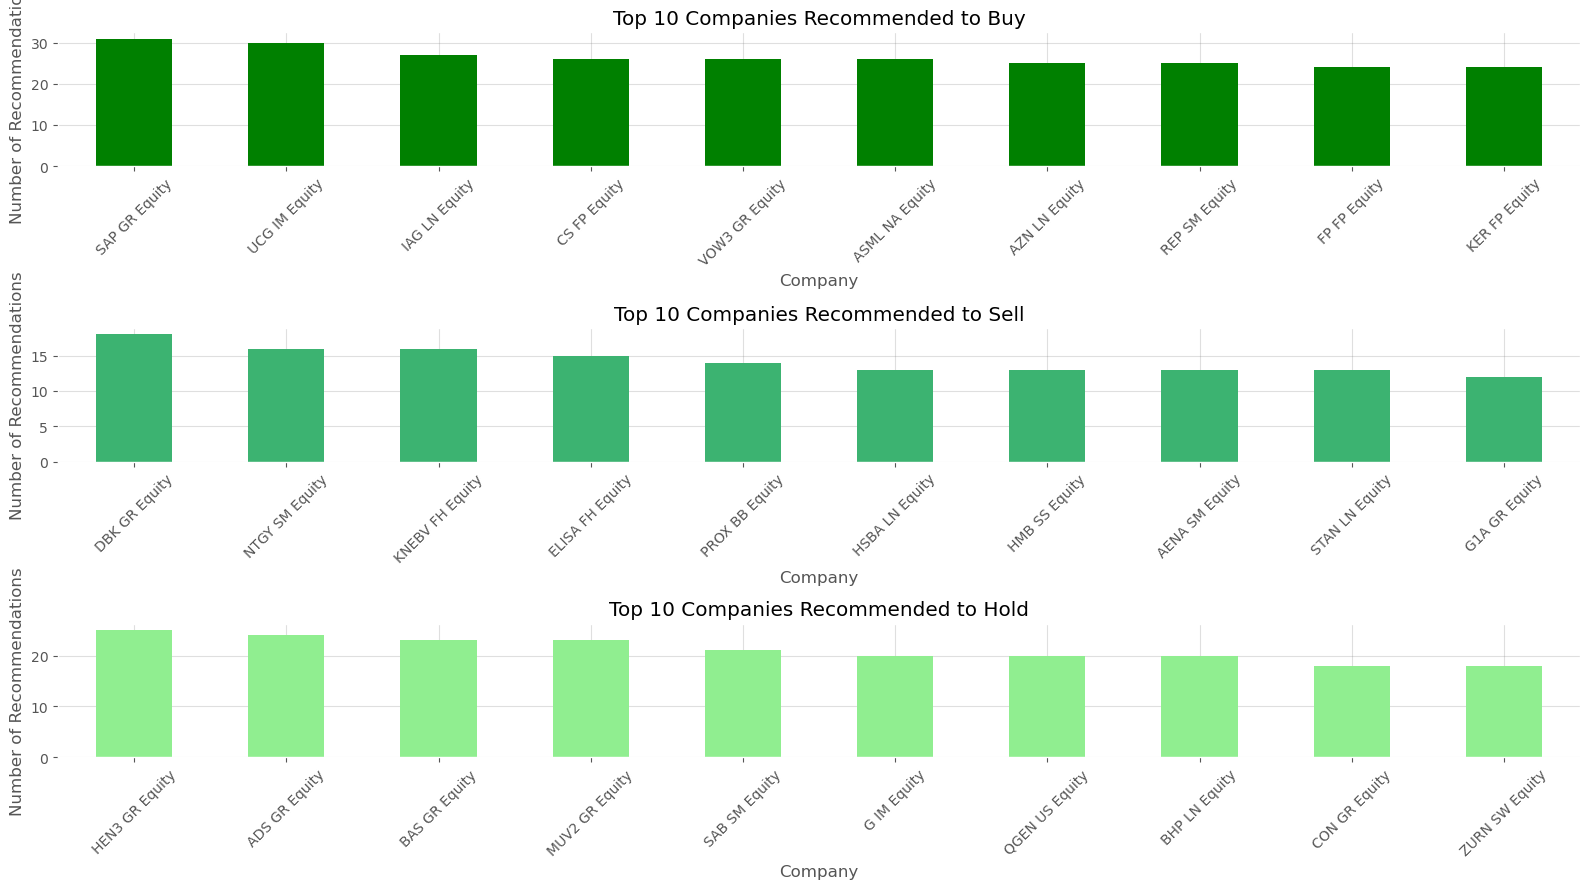

In [26]:
# Counting the top 10 companies recommended to buy and sell
buy_counts = df[df['RECOMMENDATION'] == 'Buy']['BBTICKER'].value_counts().head(10)
sell_counts = df[df['RECOMMENDATION'] == 'Sell']['BBTICKER'].value_counts().head(10)
hold_counts = df[df['RECOMMENDATION'] == 'Hold']['BBTICKER'].value_counts().head(10)

# Plotting the bar plots
fig, ax = plt.subplots(3, 1, figsize=(16, 9))

buy_counts.plot(kind='bar', ax=ax[0], color='green')#, alpha=0.7)
ax[0].set_title('Top 10 Companies Recommended to Buy')
ax[0].set_xlabel('Company')
ax[0].set_ylabel('Number of Recommendations')
ax[0].tick_params(axis='x', rotation=45)

sell_counts.plot(kind='bar', ax=ax[1], color='mediumseagreen')#, alpha=0.7)
ax[1].set_title('Top 10 Companies Recommended to Sell')
ax[1].set_xlabel('Company')
ax[1].set_ylabel('Number of Recommendations')
ax[1].tick_params(axis='x', rotation=45)

hold_counts.plot(kind='bar', ax=ax[2], color='lightgreen')#, alpha=0.7)
ax[2].set_title('Top 10 Companies Recommended to Hold')
ax[2].set_xlabel('Company')
ax[2].set_ylabel('Number of Recommendations')
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()